In [100]:
from keras.datasets import mnist
from keras.callbacks import TensorBoard
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Lambda
from keras.models import Model
from keras.losses import binary_crossentropy
import numpy as np
import matplotlib.pyplot as plt
from keras import regularizers
from datetime import datetime
from keras import backend as K
from keras.utils import plot_model
import os

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

# SHALLOW AUTOENCODER 784-2-784

In [44]:
typ=1
encoding_dim = 2

input_img = Input(shape=(784,))
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='Adam', loss='binary_crossentropy')

encoder = Model(input_img, encoded)

encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [45]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                verbose=0,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir=f'/tmp/autoencoder/{typ}__{datetime.now().hour}_{datetime.now().minute}')])

decoded_imgs = autoencoder.predict(x_test)

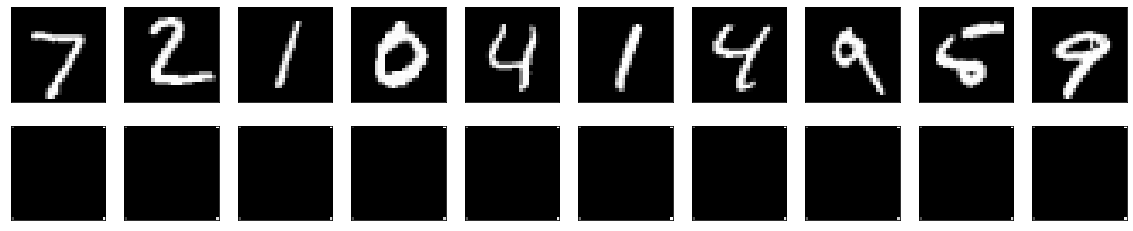

In [130]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

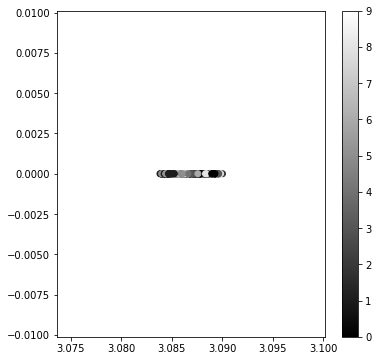

In [47]:
x_test_encoded = encoder.predict(x_test, batch_size=256)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

# SHALLOW AUTOENCODER 784-2-784 WITH REGULARIZATION

In [48]:
typ = 2
encoding_dim = 2

input_img = Input(shape=(784,))
encoded = Dense(encoding_dim, activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='Adam', loss='binary_crossentropy')

encoder = Model(input_img, encoded)

encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [49]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                verbose=0,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir=f'/tmp/autoencoder/{typ}__{datetime.now().hour}_{datetime.now().minute}')])

decoded_imgs = autoencoder.predict(x_test)

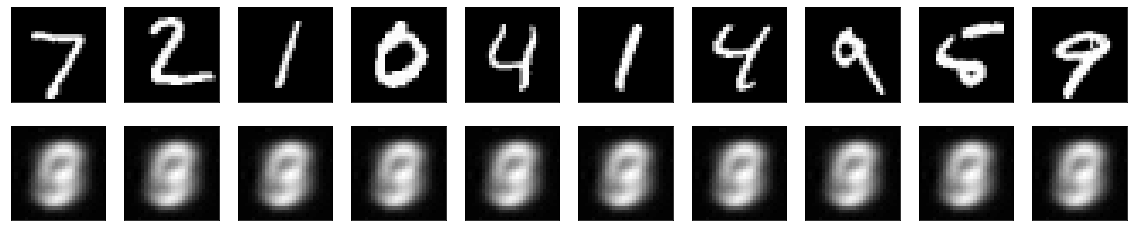

In [50]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

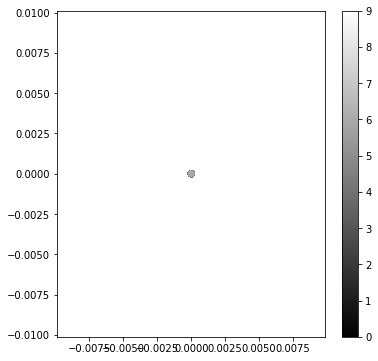

In [51]:
x_test_encoded = encoder.predict(x_test, batch_size=256)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

# CONV AUTOENCODER 

In [54]:
typ = 3
encoding_dim = 2

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='Adam', loss='binary_crossentropy')

In [57]:
x_train_c = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test_c = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

autoencoder.fit(x_train_c, x_train_c,
                epochs=3,
                batch_size=256,
                shuffle=True,
                verbose=0,
                validation_data=(x_test_c, x_test_c),
                callbacks=[TensorBoard(log_dir=f'/tmp/autoencoder/{typ}__{datetime.now().hour}_{datetime.now().minute}')])

decoded_imgs = autoencoder.predict(x_test_c)

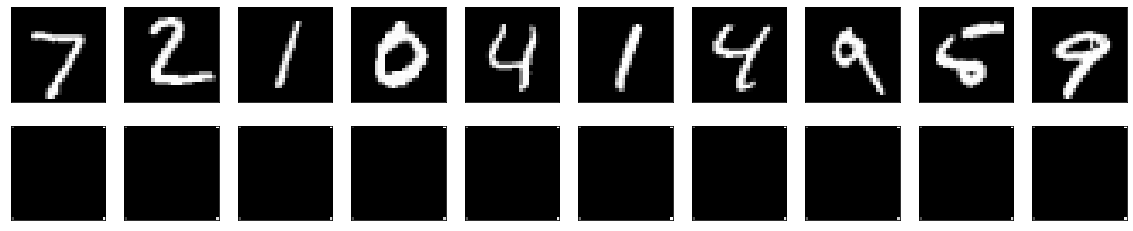

In [60]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# VARIATIONAL AUTOENCODER

In [117]:
typ=4

image_size = 28
original_dim = 784
input_shape = (original_dim, )
intermediate_dim = 128
batch_size = 128
latent_dim = 2
epochs = 50

In [118]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [119]:
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
# plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
# plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_49 (Dense)                (None, 128)          100480      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            258         dense_49[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            258         dense_49[0][0]                   
__________________________________________________________________________________________________
z (Lambda)

In [120]:
models = (encoder, decoder)
data = (x_test, y_test)

reconstruction_loss = binary_crossentropy(inputs, outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 100996    
_________________________________________________________________
decoder (Model)              (None, 784)               101520    
Total params: 202,516
Trainable params: 202,516
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 5s 76us/step - loss: 217.3563 - val_loss: 186.5713
Epoch 2/50
60000/60000 [==============================] - 4s 59us/step - loss: 182.1005 - val_loss: 176.3945
Epoch 3/50
60000/60000 [==============================] - 4s 58us/step - loss: 174.0240 - val_loss: 170.8913
Epoch 4/50
60000/60000 

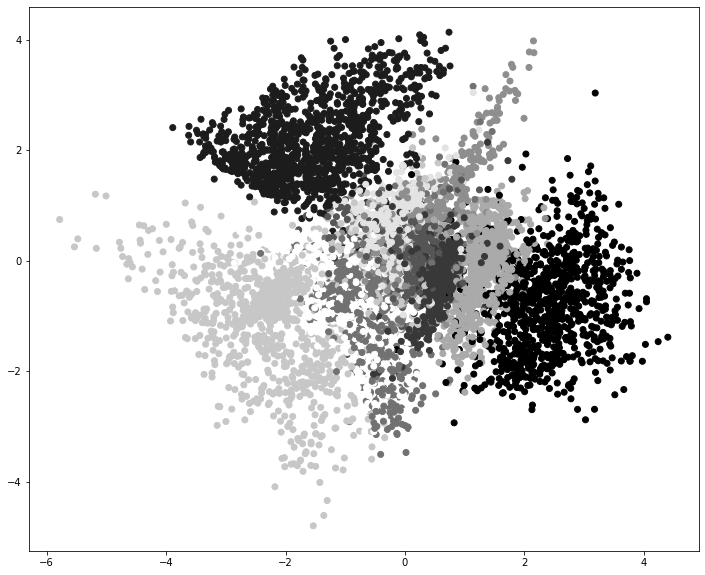

In [131]:
z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)